In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import cv2
from skimage.feature import peak_local_max
from skimage.color import rgb2gray
import pickle
from scipy.spatial.distance import cdist

0.054901960784313725


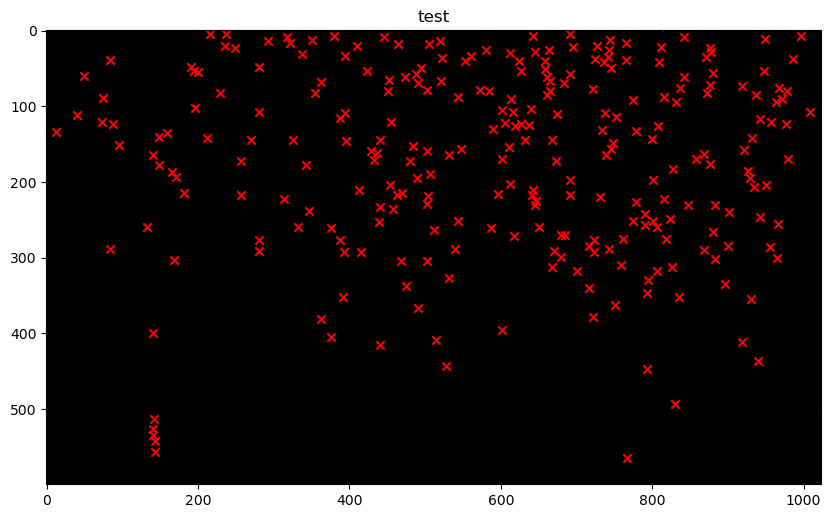

In [1243]:
homedir = '/Volumes/PIV data - Edoardo/thickSheet4PTV/'
savedir = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/'
directories = glob.glob(homedir+'Cam*')
directory = directories[9]+'/'

imagesDir = []
for imageDir in glob.glob(directory+'*.tif'):
    imagesDir.append(imageDir)
imagesDir = np.sort(imagesDir)

# TEST
testImg = rgb2gray(cv2.imread(imagesDir[0])[200:800,:])
print(np.max(testImg))
testImg /= np.max(testImg)
testImg = np.where(testImg>0.20,testImg,0)
plt.figure(figsize=(10,16))
plt.imshow(testImg,cmap='Greys_r')
# detect peaks
peaks = peak_local_max(testImg,min_distance=4)
for peak in peaks:
    plt.scatter(peak[1],peak[0],color='red',marker='x')
plt.title('test')
plt.show()

In [1244]:
directory

'/Volumes/PIV data - Edoardo/thickSheet4PTV/Cam_Date=240207_Time=161825_81mm_S00_Loop=10/'

# Read all particles

In [1245]:
pos_t = []
for imageDir in imagesDir[::]:
    image = rgb2gray(cv2.imread(imageDir)[200:800,:])
    # image = rgb2gray(cv2.imread(imageDir)[400:500,225:275])
    image /= 0.03529411764705882
    image = np.where(image>0.20,image,0)
    peaks = peak_local_max(image,min_distance=4)
    pos_t.append(peaks)
    # print(imageDir)

## Print a few to check

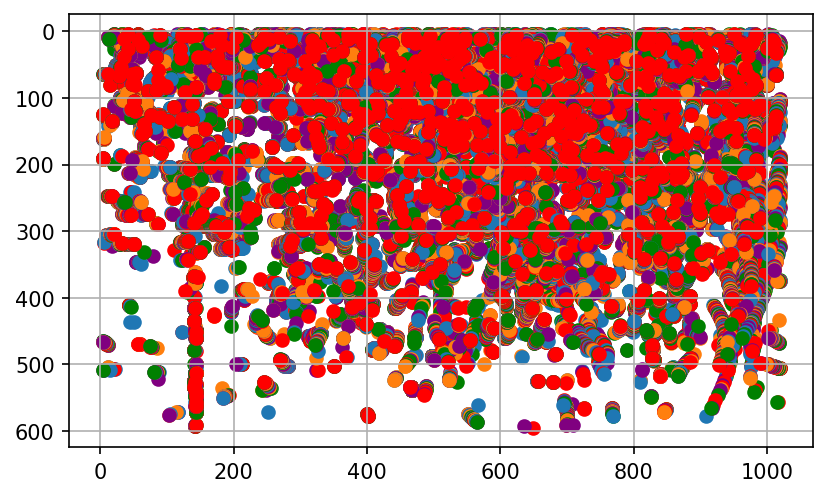

In [1246]:
plt.figure(dpi=150)
myColors = np.tile(['tab:blue','tab:orange','purple','green','red'],20)
for ip,peaks in enumerate(pos_t[:]):
    plt.scatter(peaks[:,1],peaks[:,0],color=myColors[ip])
    # for txt in peaks:
    #     plt.text(txt[1],txt[0],f'{ip}')
plt.gca().invert_yaxis()
plt.grid()
# plt.ylim(400,500)
# plt.xlim(200,400)
plt.gca().set_aspect('equal')
plt.show()

# Find trajectories

In [1247]:
class trajectory:
    def __init__(self, position):
        self.position = position
    def append(self,position):
        self.position = np.vstack((self.position,position))
    def lastPos(self,howFarInTime):
        if self.position.shape==(2,):
            return self.position
        elif howFarInTime==1:
            return self.position[-howFarInTime:][0]
        else:
            return self.position[-howFarInTime:]
        
def dist(a,b):
    return np.linalg.norm(a-b)
def vector(a,b):
    return [b[0]-a[0],b[1]-a[1]]

import quads
centre = list(np.array(testImg.shape)/2)
xspan = testImg.shape[1]
yspan = testImg.shape[0]
tree = quads.QuadTree(centre, yspan, xspan)

trajectories = []
distanceThreshold = 3 # how far can points be to be accepted

for time,particlesInFrame in enumerate(pos_t[:]): # loop over frames
    currentTree = quads.QuadTree(centre, yspan+1, xspan+1) # this is the tree at the current iteration
    # plt.scatter(pos_t[time][:,1],pos_t[time][:,0],c='green',marker='x',s=100)
    # for txt in pos_t[time]:
    #     plt.text(txt[1],txt[0],f'{time}')
    ##### INITIALIZATION STEPS #
    if time == 0 : # there are no tracks yet, let's add!
        for _,particle in enumerate(particlesInFrame):
            trajectories.append(trajectory(particle))
    if time == 1 : # just add to the trajectory
        for _,particle in enumerate(particlesInFrame):
            currentTree.insert(tuple(particle),data=False)
        for tr in trajectories:
            point_x, point_y = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].x,currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].y
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point_x,point_y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
    ##### INITIALIZATION TERMINATED ##
      
    ##### NOW LET'S EXTEND THE KNOWN TRAJECTORIES ##
    for _,particle in enumerate(particlesInFrame):
        if time <= 1 :break # this was already done in the first two timesteps
        currentTree.insert(tuple(particle))
    for _,tr in enumerate(trajectories):
        if time <= 1 :break # this shouldn't be done in the first two timesteps
        trajLen = tr.position.shape[0]
        if tr.position.shape==(2,): # needs to initialise the second point for recently-started trajectories
            point = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0]
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
            continue # I cannot do anything more with one-point trajectories
        if trajLen > 1 and trajLen <= 6 : # not enough datapoints to make a full prediction
            predicted = tr.position[-1] + vector(tr.position[-1],tr.position[-2])
            # plt.scatter(predicted[1],predicted[0],c='k',marker='x',s=100)
            if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
            point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position

        if trajLen > 6 : # can do a full prediction
            fit_y = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,0],2)) # y is the first coordinate
            predicted_y = fit_y(4)
            fit_x = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,1],2)) # x is the second coordinate
            predicted_x = fit_x(4)
            predicted = [predicted_y,predicted_x]
            # plt.scatter(predicted_x,predicted_y,c='k',marker='x')
            # plt.plot(fit_x(np.arange(5)),fit_y(np.arange(5)),c='k',linestyle='--')
            if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
            point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
            if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
            tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position
    
    # aggiungi tutte le particles che non sono in una traiettoria
    pointsInTree = np.transpose(([point.x for point in currentTree._root.all_points()],[point.y for point in currentTree._root.all_points()]))
    lastPosOfTraj = np.array([list(tr.lastPos(1)) for tr in trajectories])
    for unmatchedPoint in pointsInTree[(pointsInTree[:,None]!=lastPosOfTraj).any(-1).all(1)]: # https://stackoverflow.com/questions/66674537/python-numpy-get-difference-between-2-two-dimensional-array
        trajectories.append(trajectory(unmatchedPoint))
        # print(time,unmatchedPoint)
    
# for tr in trajectories:
#     if tr.position.shape==(2,): continue
#     plt.plot(tr.position[:,1],tr.position[:,0],marker='o')

'''
NEED TO: 
    - connect tracks that skip
'''

'\nNEED TO: \n    - connect tracks that skip\n'

In [1248]:
with open(savedir+f'trajectories_{directory[-40:-1]}', "wb") as fp:   #Pickling
    pickle.dump(trajectories, fp)

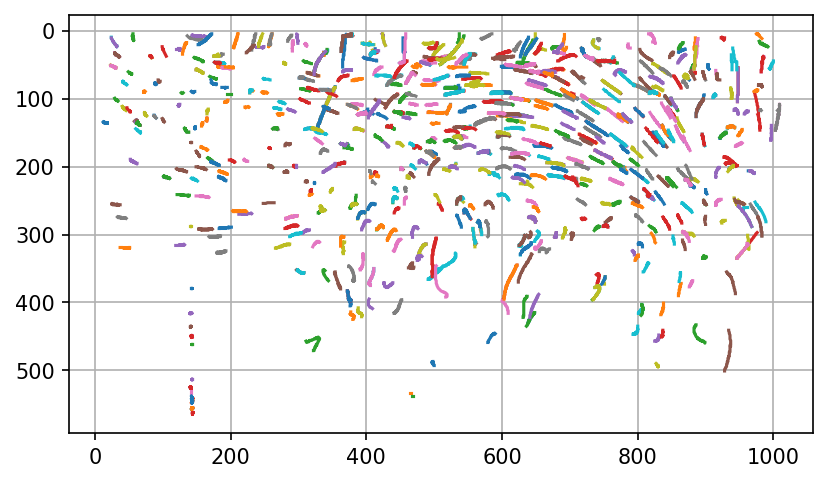

In [1249]:
plt.figure(dpi=150)
for tr in trajectories:
    if tr.position.shape==(2,): continue
    if tr.position.shape[0]<50:continue
    plt.plot(tr.position[:,1],tr.position[:,0])
plt.grid()
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
# plt.ylim(400,420)
# plt.xlim(50,75)
plt.show()

# LOOP

In [1251]:
directories = glob.glob(homedir+'Cam*')
from tqdm import tqdm
for directory in tqdm(directories):
    directory += '/'
    imagesDir = []
    for imageDir in glob.glob(directory+'*.tif'):
        imagesDir.append(imageDir)
    imagesDir = np.sort(imagesDir)

    pos_t = []
    for imageDir in imagesDir[::]:
        image = rgb2gray(cv2.imread(imageDir)[200:800,:])
        # image = rgb2gray(cv2.imread(imageDir)[400:500,225:275])
        image /= 0.03529411764705882
        image = np.where(image>0.20,image,0)
        peaks = peak_local_max(image,min_distance=4)
        pos_t.append(peaks)

    centre = list(np.array(testImg.shape)/2)
    xspan = testImg.shape[1]
    yspan = testImg.shape[0]
    tree = quads.QuadTree(centre, yspan, xspan)

    trajectories = []
    distanceThreshold = 3 # how far can points be to be accepted

    for time,particlesInFrame in enumerate(pos_t[:]): # loop over frames
        currentTree = quads.QuadTree(centre, yspan+1, xspan+1) # this is the tree at the current iteration
        # plt.scatter(pos_t[time][:,1],pos_t[time][:,0],c='green',marker='x',s=100)
        # for txt in pos_t[time]:
        #     plt.text(txt[1],txt[0],f'{time}')
        ##### INITIALIZATION STEPS #
        if time == 0 : # there are no tracks yet, let's add!
            for _,particle in enumerate(particlesInFrame):
                trajectories.append(trajectory(particle))
        if time == 1 : # just add to the trajectory
            for _,particle in enumerate(particlesInFrame):
                currentTree.insert(tuple(particle),data=False)
            for tr in trajectories:
                point_x, point_y = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].x,currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0].y
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point_x,point_y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
        ##### INITIALIZATION TERMINATED ##
        
        ##### NOW LET'S EXTEND THE KNOWN TRAJECTORIES ##
        for _,particle in enumerate(particlesInFrame):
            if time <= 1 :break # this was already done in the first two timesteps
            currentTree.insert(tuple(particle))
        for _,tr in enumerate(trajectories):
            if time <= 1 :break # this shouldn't be done in the first two timesteps
            trajLen = tr.position.shape[0]
            if tr.position.shape==(2,): # needs to initialise the second point for recently-started trajectories
                point = currentTree.nearest_neighbors(tuple(tr.lastPos(1)),count=1)[0]
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the last position in the trajectory
                continue # I cannot do anything more with one-point trajectories
            if trajLen > 1 and trajLen <= 6 : # not enough datapoints to make a full prediction
                predicted = tr.position[-1] + vector(tr.position[-1],tr.position[-2])
                # plt.scatter(predicted[1],predicted[0],c='k',marker='x',s=100)
                if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
                point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position

            if trajLen > 6 : # can do a full prediction
                fit_y = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,0],2)) # y is the first coordinate
                predicted_y = fit_y(4)
                fit_x = np.poly1d(np.polyfit(np.arange(4),tr.lastPos(4)[:,1],2)) # x is the second coordinate
                predicted_x = fit_x(4)
                predicted = [predicted_y,predicted_x]
                # plt.scatter(predicted_x,predicted_y,c='k',marker='x')
                # plt.plot(fit_x(np.arange(5)),fit_y(np.arange(5)),c='k',linestyle='--')
                if len(currentTree.nearest_neighbors(tuple(predicted),count=1))==0: continue # didn't find anything (for some reason)
                point = currentTree.nearest_neighbors(tuple(predicted),count=1)[0]
                if quads.euclidean_distance(quads.Point(point.x,point.y),quads.Point(tr.lastPos(1)[0],tr.lastPos(1)[1])) > distanceThreshold:continue # cannot be too far
                tr.append([point.x,point.y]) # appends to the trajectory the point in the current tree which is closer to the predicted position
        
        # aggiungi tutte le particles che non sono in una traiettoria
        pointsInTree = np.transpose(([point.x for point in currentTree._root.all_points()],[point.y for point in currentTree._root.all_points()]))
        lastPosOfTraj = np.array([list(tr.lastPos(1)) for tr in trajectories])
        for unmatchedPoint in pointsInTree[(pointsInTree[:,None]!=lastPosOfTraj).any(-1).all(1)]: # https://stackoverflow.com/questions/66674537/python-numpy-get-difference-between-2-two-dimensional-array
            trajectories.append(trajectory(unmatchedPoint))

    with open(savedir+f'trajectories_{directory[-40:-1]}', "wb") as fp:   #Pickling
        pickle.dump(trajectories, fp)

100%|██████████| 41/41 [8:51:29<00:00, 777.79s/it]   


# Load looped trajectories 

In [1260]:
dt = 1 

trajFiles = []

for trajFile in glob.glob('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2024-02-07/trajec*'):
    trajFiles.append(trajFile)

trajFiles = np.sort(trajFiles)

for trajFile in trajFiles:
    with open(trajFile, "rb") as fp:   # Unpickling
        loadedTrajectories = pickle.load(fp)
    velocities = np.array([np.nan,np.nan])
    for i,tr in enumerate(loadedTrajectories[:]):
        if tr.position.shape[0]<50:continue
        velocities = np.vstack((velocities,np.gradient(tr.position,axis=0)/dt))
    print(np.nanmean(velocities))

0.05597614746318014
0.03874650216229967
0.0261016131155213
0.026537156666821583
0.00942786558031478
-0.017583846475757756
-0.0328228668415368
-0.021761854264505377
-0.020363464638733737
0.21558221950385867
0.1364027625875967
0.05077111633132469
0.08613257194043221
0.08527071224715121
0.09604325480980494
0.18153668940033302
0.20514304168797265
0.35254863472694536
0.27765380223454517
0.4042058000408504
0.3172871953663407
0.22308248982475445
0.1636877156696554
0.2029885027925986
0.32921666360004204
0.50604873357783
0.2570050060857692
0.09992927168572271
0.042854750640145156
-0.056743462329970386
-0.06039295490563319
-0.015272273338338251
0.03194381702889458
0.11502075755905801
0.13748512966928383
0.19165136360084395
0.35960884176250807
0.18049132429913242
0.11327561327561328
0.10132743362831859
0.5060531523414761


# Get velocities

In [ ]:
dt = 1 # s
velocities = np.array([np.nan,np.nan])

for i,tr in enumerate(trajectories[1:]):
    if tr.position.shape[0]<50:continue
    velocities = np.vstack((velocities,np.gradient(tr.position,axis=0)/dt))

nbins = 13
plt.hist(velocities[:,0].flatten(),label='y-direction',alpha=0.5,bins=nbins)
plt.hist(velocities[:,1].flatten(),label='x-direction',alpha=0.5,bins=nbins)
# plt.plot(200+np.linspace(-800,800,200),
#          np.exp(-(np.linspace(-800,800,200)/5e2)**2)*15,
#          label='gaussian1 line')

plt.title('PDF velocity w/ direction')
plt.xlabel('velocity []')
plt.ylabel('PDF []')
plt.yscale('log')
# plt.xlim(-50,50)
# plt.ylim(1e0,1e5)
plt.grid()
plt.legend()
plt.show()

In [ ]:
len(trajectories)